In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_ENABLE_CUDNN_OPTS'] = '1'
os.environ['DEEPREG_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done


In [2]:
class video_convert:

    def __init__(self,path_video_dir, file_type, path_data_save, trget_nr_fremes, trget_width, trget_height, color):
        self.path_video_dir = path_video_dir # input videos dir
        self.file_type = file_type
        self.path_data_save = path_data_save # dir data save 
        self.trget_nr_fremes = trget_nr_fremes
        self.trget_width = trget_width
        self.trget_height = trget_height
        self.color = color

    
    def label_create(self):
        # creaza lista de directoare in care se afla fisierele
        self.list_label_name = os.listdir(self.path_video_dir)
        
        # creaza valoare categorica a etichetelor
            # numara cate fisiere sunt in directorul respectiv
        nr_label = len(self.list_label_name)
            # creaza o lista cu numere echivalenta etichetelor
        self.list_label_categorical = range(nr_label)
            # trasforma lista in valori categorice
        self.list_label_categorical = to_categorical(self.list_label_categorical, num_classes = nr_label)
        
        # creaza dictionar intre denumire si valoarea categorica
        self.dict_label = {}
        for key,  value in zip(self.list_label_name, self.list_label_categorical):
            self.dict_label[key] = value
            # print(value)
        
        return self.list_label_name, self.list_label_categorical, self.dict_label

    
    def video_pre_processing(self, path_video):

        # determina raportul dintre latimea imagini dorite si inaltimea acesteia dorite
        target_ratio = self.trget_width / self.trget_height
        
        # determina caracteristicile filmuletului
        capture = cv2.VideoCapture(path_video)                       # creaza obiectul CV
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))    # extrage nr total de cadre
        width_capture = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   # extrage valoare latimi imagini
        height_capture = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) # extrage valoare inaltimi imagini
        fps = capture.get(cv2.CAP_PROP_FPS)                          # extrage valoarea numarului de cadre pe secunda
        time = total_frames / fps                                    # determina timpul
        
        
        # se determina pasul de rulare tinta pe total frames
        step = total_frames / self.trget_nr_fremes
        
        # genereaza lista de fremuri care sunt extrase din total frames
        list_fremes = []
        for i in range(self.trget_nr_fremes):
            list_fremes.append(int(i*step))
            
        # in cazul in care valoarea (indexului) din list_fremes este mai mare decat valoarea ultimului index din 'capture' (total_frames - 1), 
        # se corecteaza ultimul index cu total_frames - 1
        if list_fremes[-1] > total_frames - 1:
            list_fremes[-1] = total_frames -1
        # print(list_fremes)
        
        
        frames_list = []
        for i in list_fremes:
            # seteaza freme-ul care urmeaza sa fie preluat 
            capture.set(cv2.CAP_PROP_POS_FRAMES,i)
            # .read() returnează un bool (adevărat/fals). Dacă cadrul este citit corect, va fi success=True.
            # .read() returneaza imaginea setata capture.set(cv2.CAP_PROP_POS_FRAMES,nr)
            success, frame = capture.read()
            
            # in cazul in care success = False abandoneaza filmuletul 
            if not success:
                print('errrr')
                err = 1
                break
        
            # in cazul in care latimea este mai mare decat inaltimea
            if width_capture / height_capture > target_ratio:
                # determina inaltimea echivalenta pentru target_ratio
                height = int(width_capture / target_ratio)
                # genereaza pad-ul (cu raportul target_ratio) pe care se monteza imaginea 
                padded_image = np.zeros((height,width_capture,3), dtype=np.uint8)
                # centreaza imaginea pe inaltimea pad-ului
                start = int((height - height_capture) / 2)
                end = start + height_capture
                # aplica imaginea pe pad
                padded_image[start:end,:,:]=frame
                # redimesioneaza imaginea in functie de rezolutia dorita 
                frame = cv2.resize(padded_image, (self.trget_width, self.trget_height))
                
            # in cazul in care latimea este mai mica decat inaltimea
            elif width_capture / height_capture < target_ratio:
                # determina latimea echivalenta pentru target_ratio
                width = int(height_capture * target_ratio)
                # genereaza pad-ul (cu raportul target_ratio) pe care se monteza imaginea 
                padded_image = np.zeros((height_capture,width,3), dtype=np.uint8)
                # centreaza imaginea pe ilatimea pad-ului
                start = int((width - width_capture)/2)
                end = start + width_capture
                # aplica imaginea pe pad
                padded_image[:,start:end,:]=frame
                # redimesioneaza imaginea in functie de rezolutia dorita 
                frame = cv2.resize(padded_image, (self.trget_width, self.trget_height))
        
            # daca latimea / inaltimea = target_ratio
            else:
                # redimesioneaza imaginea in functie de rezolutia dorita
                frame = cv2.resize(frame, (self.trget_width, self.trget_height))
            
           # selecteaza tipul de imagine, RGB sau Grayscale 
            if self.color == 1:
                # Convert from BGR to Grayscale
                frame=cv2.cvtColor(frame , cv2.COLOR_BGR2GRAY)
            elif self.color == 3:
                # Convert from BGR to RGB
                frame=cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)
            else:
                print('Eror image color')
               

            # add image to list
            frames_list.append(frame)

        # dezactiveaza obiectul 'capture'
        capture.release()
        cv2.destroyAllWindows()

        # trasforma cadrele existelte in lista frames_list, in matrice array
        self.frames_list = np.array(frames_list, dtype=np.float32)
    
        return self.frames_list


    def create_data_set(self):

        self.label_create()

        Y = []
        X = []
        # itereaza lista de label-uri
        for dir_label in self.list_label_name:
            # itereaza fisierele din directorul 'label'
            for path_video in os.listdir(self.path_video_dir + '/' + dir_label):
                # verifica daca fisierul are extensia dorita 
                if path_video.endswith(self.file_type):
                    # creaza calea (path-ul) catre fisierul care urmeaza procesat
                    path_video = self.path_video_dir + '/' + dir_label + '/' + path_video
                    # adauga in lista eticheta si fisierul procesat
                    Y.append(self.dict_label[dir_label])
                    X.append(self.video_pre_processing(path_video))
        
        # converteste lista in array    
        self.Y = np.array(Y, dtype=np.float32)
        self.X = np.array(X, dtype=np.float32)
        
        # creaza data-set
        self.video_dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y)) 
        
        return self.video_dataset


    def save_data(self):
        
        # lanseaza in executie metoda self.create_data_set()
        self.create_data_set()

        # sterge directorul si continutul acestuia, pentru a crea mediul noului set de date
        try:
            folder_path = self.path_data_save 
            shutil.rmtree(folder_path)
            print('The folder and its contents have been deleted.')
        except:
            print('The folder was not deleted.')

        # salveaza instregul set de date
        path = os.path.join(self.path_data_save + '/' + 'dataset')
        tf.data.Dataset.save(self.video_dataset, path)

        # desparte in date de antrenament si date de evaluare
        x_train, x_val, y_train, y_val = train_test_split(self.X, self.Y, random_state=923, test_size=0.2, train_size=0.8)
        print('x_train', x_train.shape)
        print('y_train', y_train.shape)
        print('x_val', x_val.shape)
        print('y_val', y_val.shape)

        # salveaza datele de antrenament
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
        path = os.path.join(self.path_data_save + '/' + 'train_dataset')
        tf.data.Dataset.save(train_dataset, path)

        # salveaza datele de validare
        val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)) 
        path = os.path.join(self.path_data_save + '/' + 'val_dataset')
        tf.data.Dataset.save(val_dataset, path)

        # salveaza numele etichetelor
        df_list_label_name = pd.DataFrame(self.list_label_name)
        df_list_label_name.to_csv(self.path_data_save + '/' + 'list_label_name.csv')

        # salveaza dictionarul eticheta : valoarea categorica
        path = self.path_data_save + '/' + 'dict_label.npy'
        np.save(path, self.dict_label)

    def test_dataset(self,):

        # genereaza un numar random in intervalul 0 - nr de date 
        nr = np.random.randint(low = 0, high=self.X.shape[0], size=1, dtype=int)
        nr = nr[0]
        # print(nr)

        # extrage inregistrarea conform nr
        video_print = self.X[nr]

        # extrage din dictionar numele actiuni
        for key, value in self.dict_label.items():
            if str(value) == str(self.Y[nr]):
                print('aciunea : ', key)
      
        # listeaza valoarea categorica a actiuni
        print('valoarea categorica a actiuni : ', self.Y[nr])

        # printeaza cadrele rezultate, a inregistrari cu nr 
        plt.figure(figsize=(16,9)) 
        for i in range(10):
            plt.subplot(int(self.trget_nr_fremes/4)+1, 4, i+1)   
            plt.imshow(video_print[i])
            #plt.gray()
            plt.axis('off')
        plt.show()

                

In [3]:
pre_processing = video_convert('video_test', '.avi', 'dataset', 10, 320, 240, 3)

In [4]:
pre_processing.save_data()

The folder was not deleted.
x_train (478, 10, 240, 320, 3)
y_train (478, 5)
x_val (120, 10, 240, 320, 3)
y_val (120, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

aciunea :  shoot_ball
valoarea categorica a actiuni :  [0. 0. 1. 0. 0.]


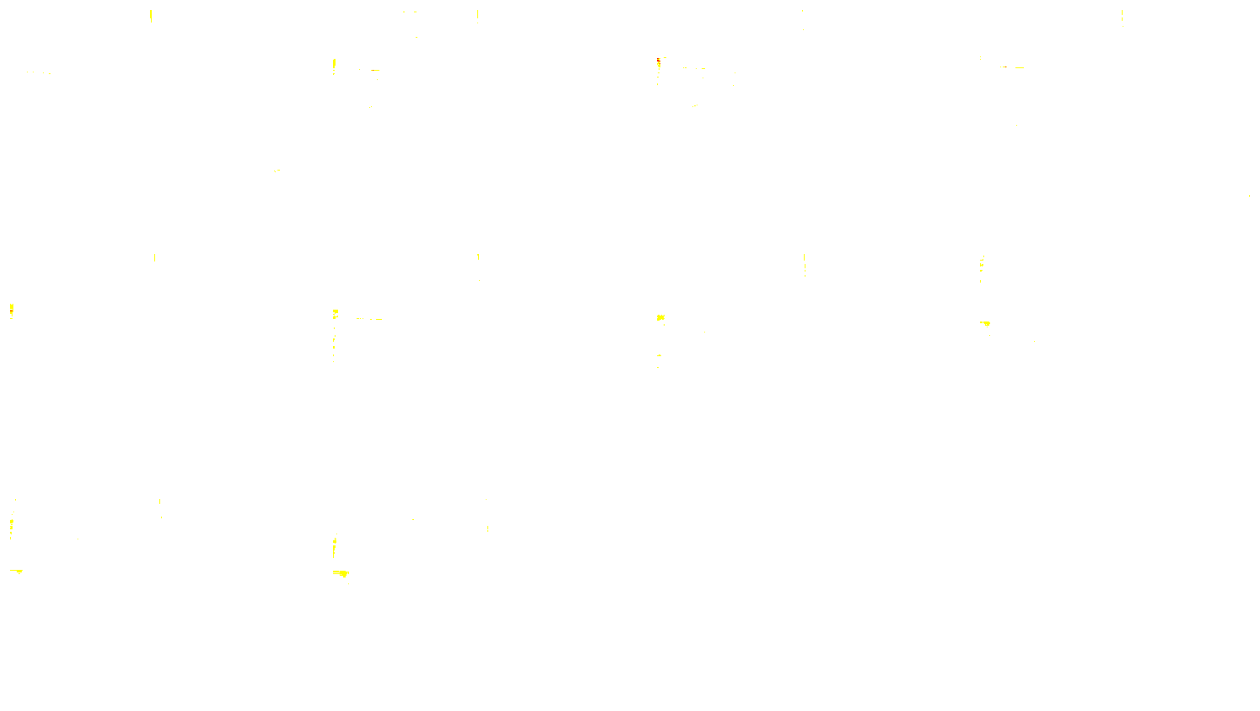

In [5]:
pre_processing.test_dataset()